In [1]:
import argparse
import itertools

from src.pipeline import pipeline
from src.training_utils import training_utils

In [2]:
EXP_HPARAMS = {
    "params": (
        {},
    ),
    "seeds": (420,),
}
config = training_utils.get_config("MNIST")
for hparams_overwrite_list, seed in itertools.product(EXP_HPARAMS["params"], EXP_HPARAMS["seeds"]):
    hparams_str = ""
    for k, v in hparams_overwrite_list.items():
        config[k] = v
        hparams_str += str(k) + "-" + str(v) + "_"
    config["model_architecture"] = "bigbigan"
    config["hparams_str"] = hparams_str.strip("_")
    config["seed"] = seed
    #set batch size
    config["bs"] = 1

In [3]:
pip = pipeline.BigBiGANInference.from_checkpoint(checkpoint_path="./data/MNIST/bigbigan/checkpoints/checkpoint_40.pth", data_path="./data", config=config)


In [4]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

0it [00:00, ?it/s]


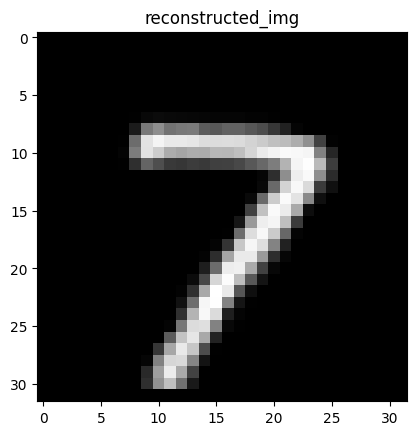

In [5]:
pip.inference()

In [6]:
import torch
from torchvision import datasets, transforms
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


In [7]:
def plot_images(images, labels, title):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 3))
    fig.suptitle(title, fontsize=16)
    for i, (img, label) in enumerate(zip(images, labels)):
        axs[i].imshow(np.transpose(img.numpy(), (1, 2, 0)).squeeze(), cmap='gray')
        axs[i].set_title(f'Label: {label.item()}')
        axs[i].axis('off')
    plt.show()

def get_dataloader(dataset, batch_size=1, class_label=[0]):
    filtered_indices = [i for i, (_, label) in enumerate(dataset) if label in class_label]
    filtered_dataset = torch.utils.data.Subset(dataset, filtered_indices)
    dataloader = torch.utils.data.DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)
    #Print the number of images in the dataloader
    print(f"Number of images in dataloader: {len(dataloader)}")
    #PLOT IMAGES
    return dataloader
    
def plot_batch(dataloader, title):
    for batch_images, batch_labels in dataloader:
        # Plot the images from the batch
        plot_images(batch_images, batch_labels, 'Sample Images from class: ')
        break  # Only plot the first batch for demonstration purposes

def encode_batch(pip, dataloader):
    print("Dataloader size: ", len(dataloader))
    encoded_images = []
    for batch_images, batch_labels in dataloader:
        #batch_images = batch_images.unsqueeze(0)
        batch_images = batch_images.to(config.device)
        z_img = pip.encode(batch_images)
        encoded_images.append(z_img.detach().cpu().numpy())
    #encoded_images = np.array(encoded_images)
    encoded_images = np.concatenate(encoded_images, axis=0)

    return encoded_images

In [44]:
dt_mnist = get_dataloader(train_dataset, batch_size=1, class_label=[0,1,2,3,4,5,6,7,8,9])

Number of images in dataloader: 60000


In [8]:
dt_zero = get_dataloader(test_dataset, batch_size=4, class_label=[0])
dt_nine = get_dataloader(test_dataset, batch_size=1, class_label=[9])
dt_seven = get_dataloader(test_dataset, batch_size=1, class_label=[7])

Number of images in dataloader: 245
Number of images in dataloader: 1009
Number of images in dataloader: 1028


Inspecting data: 
Batch shape:  torch.Size([4, 1, 32, 32])


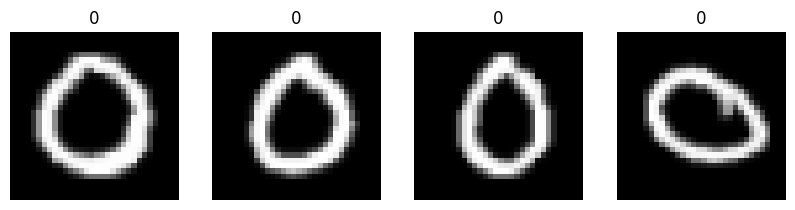

In [9]:
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
print("Inspecting data: ")
for _, data in enumerate(dt_zero):
    print("Batch shape: ", data[0].shape)
    fig, ax = plt.subplots(1, 4, figsize=(10, 4))

    for i in range(4):
        # Ture 3D tensor to 2D tensor due to image's single channel
        ax[i].imshow(data[0][i].squeeze(), cmap="gray")
        ax[i].axis("off")
        ax[i].set_title(labels[data[1][i]])
    plt.show()
    # And don't forge
    break

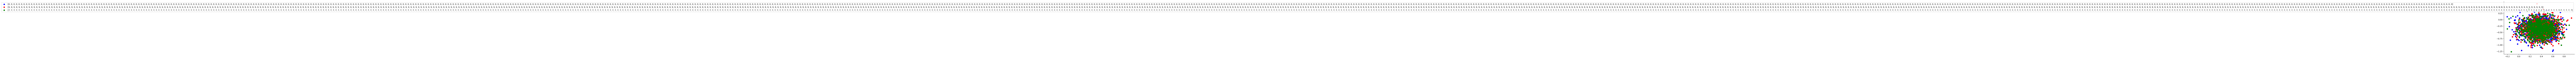

In [43]:
show = True
def get_point(dataloader, pip, show=True):
    points = []
    label_idcs = []
    for i, data in enumerate(dataloader):
        img, label = [d.to("cuda") for d in data]
        # We only need to encode the validation images
        proj = pip.encode(img)
        points.extend(proj.detach().cpu().numpy())
        label_idcs.extend(label.detach().cpu().numpy())
        del img, label

    return np.array(points), label_idcs

point_zero, label_zero = get_point(dt_zero, pip, show)
point_nine, label_nine = get_point(dt_nine, pip, show)
point_seven, label_seven = get_point(dt_seven, pip, show)

# Creating a scatter plot
fig, ax = plt.subplots()
ax.scatter(point_zero[:, 0], point_zero[:, 1], c="blue", label=label_zero)
ax.scatter(point_nine[:, 0], point_nine[:, 1], c="red", label=label_nine)
ax.scatter(point_seven[:, 0], point_seven[:, 1], c="green", label=label_seven)
ax.legend()

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


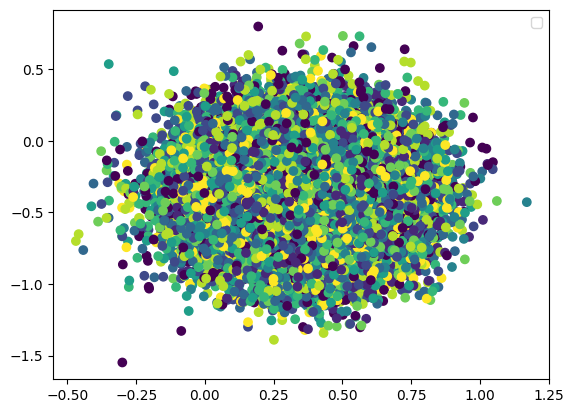

In [45]:
point_mnist, label_mnist = get_point(dt_mnist, pip, show)
# Creating a scatter plot
fig, ax = plt.subplots()
ax.scatter(point_mnist[:, 0], point_mnist[:, 1], c=label_mnist)
ax.legend()


0it [00:00, ?it/s]

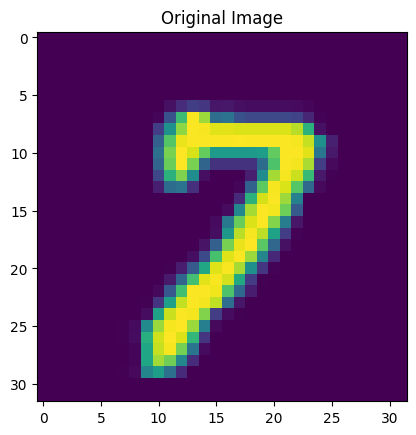

0it [00:00, ?it/s]


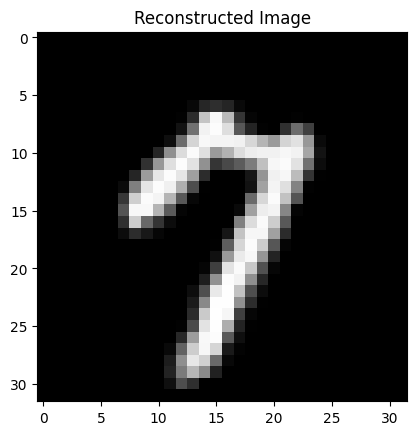

In [10]:
#my inference
pip.inference_my(dt_seven)

In [ ]:
#plot some images
plot_batch(dt_zero, "Zero")
plot_batch(dt_nine, "Nine")
plot_batch(dt_seven, "Seven")

In [23]:
dt_zero = get_dataloader(test_dataset, batch_size=1, class_label=[0])
z_zero = encode_batch(pip, dt_zero)
print(z_zero.shape)
dt_one = get_dataloader(test_dataset, batch_size=1, class_label=[1])
z_one = encode_batch(pip, dt_zero)
print(z_one.shape)
dt_two = get_dataloader(test_dataset, batch_size=1, class_label=[2])
z_two = encode_batch(pip, dt_two)
print(z_two.shape)
dt_three = get_dataloader(test_dataset, batch_size=1, class_label=[3])
z_three = encode_batch(pip, dt_three)
print(z_three.shape)
dt_four = get_dataloader(test_dataset, batch_size=1, class_label=[4])
z_four = encode_batch(pip, dt_four)
print(z_four.shape)
dt_five = get_dataloader(test_dataset, batch_size=1, class_label=[5])
z_five = encode_batch(pip, dt_five)
print(z_five.shape)
dt_six = get_dataloader(test_dataset, batch_size=1, class_label=[6])
z_six = encode_batch(pip, dt_six)
print(z_six.shape)
dt_seven = get_dataloader(test_dataset, batch_size=1, class_label=[7])
z_seven = encode_batch(pip, dt_seven)
print(z_seven.shape)
dt_eight = get_dataloader(test_dataset, batch_size=1, class_label=[8])
z_eight = encode_batch(pip, dt_eight)
print(z_eight.shape)
dt_nine = get_dataloader(test_dataset, batch_size=1, class_label=[9])
z_nine = encode_batch(pip, dt_nine)
print(z_nine.shape)

Number of images in dataloader: 980
Dataloader size:  980
(980, 100)
Number of images in dataloader: 1135
Dataloader size:  980
(980, 100)
Number of images in dataloader: 1032
Dataloader size:  1032
(1032, 100)
Number of images in dataloader: 1010
Dataloader size:  1010
(1010, 100)
Number of images in dataloader: 982
Dataloader size:  982
(982, 100)
Number of images in dataloader: 892
Dataloader size:  892
(892, 100)
Number of images in dataloader: 958
Dataloader size:  958
(958, 100)
Number of images in dataloader: 1028
Dataloader size:  1028
(1028, 100)
Number of images in dataloader: 974
Dataloader size:  974
(974, 100)
Number of images in dataloader: 1009
Dataloader size:  1009
(1009, 100)


In [25]:

all_data_np = np.concatenate([z_zero, z_one, z_two, z_three, z_four, z_five, z_six, z_seven, z_eight, z_nine], axis=0)

# Convert NumPy array to PyTorch tensor
all_data = torch.from_numpy(all_data_np)
# Flatten the data if needed
all_data_flattened = all_data.view(all_data.size(0), -1)


# Apply PCA on the concatenated dataset
pca = PCA(n_components=2)
all_cords_np = pca.fit_transform(all_data_flattened.numpy())

# Convert NumPy array back to PyTorch tensor
all_cords = torch.from_numpy(all_cords_np)

# Split the PCA coordinates back into class-specific arrays
zero_cords = all_cords[:len(z_zero)]
one_cords = all_cords[len(z_zero):len(z_zero) + len(z_one)]
two_cords = all_cords[len(z_zero) + len(z_one):len(z_zero) + len(z_one) + len(z_two)]
three_cords = all_cords[len(z_zero) + len(z_one) + len(z_two):len(z_zero) + len(z_one) + len(z_two) + len(z_three)]
four_cords = all_cords[len(z_zero) + len(z_one) + len(z_two) + len(z_three):len(z_zero) + len(z_one) + len(z_two) + len(z_three) + len(z_four)]
five_cords = all_cords[len(z_zero) + len(z_one) + len(z_two) + len(z_three) + len(z_four):len(z_zero) + len(z_one) + len(z_two) + len(z_three) + len(z_four) + len(z_five)]
six_cords = all_cords[len(z_zero) + len(z_one) + len(z_two) + len(z_three) + len(z_four) + len(z_five):len(z_zero) + len(z_one) + len(z_two) + len(z_three) + len(z_four) + len(z_five) + len(z_six)]
seven_cords = all_cords[len(z_zero) + len(z_one) + len(z_two) + len(z_three) + len(z_four) + len(z_five) + len(z_six):len(z_zero) + len(z_one) + len(z_two) + len(z_three) + len(z_four) + len(z_five) + len(z_six) + len(z_seven)]
eight_cords = all_cords[len(z_zero) + len(z_one) + len(z_two) + len(z_three) + len(z_four) + len(z_five) + len(z_six) + len(z_seven):len(z_zero) + len(z_one) + len(z_two) + len(z_three) + len(z_four) + len(z_five) + len(z_six) + len(z_seven) + len(z_eight)]
nine_cords = all_cords[len(z_zero) + len(z_one) + len(z_two) + len(z_three) + len(z_four) + len(z_five) + len(z_six) + len(z_seven) + len(z_eight):]



In [20]:
pca = PCA(n_components=2)
zero_cords = pca.fit_transform(z_batchzero)
nine_cords = pca.fit_transform(z_batchnine)
seven_cords = pca.fit_transform(z_batchseven)

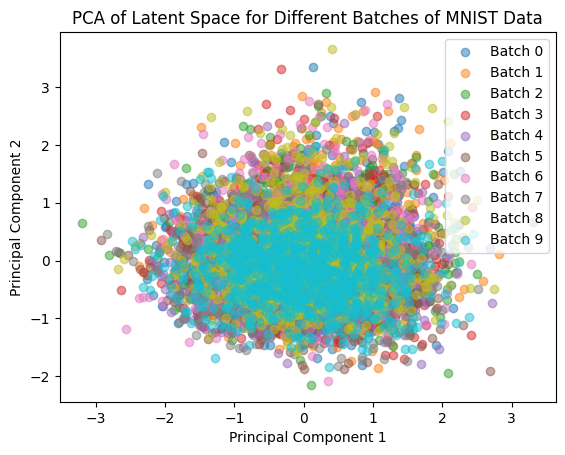

In [26]:
plt.scatter(zero_cords[:, 0], zero_cords[:, 1], label='Batch 0', alpha=0.5)
plt.scatter(one_cords[:, 0], one_cords[:, 1], label='Batch 1', alpha=0.5)
plt.scatter(two_cords[:, 0], two_cords[:, 1], label='Batch 2', alpha=0.5)
plt.scatter(three_cords[:, 0], three_cords[:, 1], label='Batch 3', alpha=0.5)
plt.scatter(four_cords[:, 0], four_cords[:, 1], label='Batch 4', alpha=0.5)
plt.scatter(five_cords[:, 0], five_cords[:, 1], label='Batch 5', alpha=0.5)
plt.scatter(six_cords[:, 0], six_cords[:, 1], label='Batch 6', alpha=0.5)
plt.scatter(seven_cords[:, 0], seven_cords[:, 1], label='Batch 7', alpha=0.5)
plt.scatter(eight_cords[:, 0], eight_cords[:, 1], label='Batch 8', alpha=0.5)
plt.scatter(nine_cords[:, 0], nine_cords[:, 1], label='Batch 9', alpha=0.5)
plt.title('PCA of Latent Space for Different Batches of MNIST Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()